In [1]:
## Victorian400 데이터셋 다운 후 압축 해제

!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data GAN-Colorization
!unzip -q Victorian400-GAN-colorization-data.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0
Receiving objects: 100% (45/45), 11.62 KiB | 2.90 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Downloading...
From: https://drive.google.com/uc?id=1dZxoBIWmbuF-Oy_XZoS1z9EjPJwkTmy6
To: /content/Victorian400-GAN-colorization-data.zip
100% 508M/508M [00:08<00:00, 61.2MB/s]
Victorian400-GAN-colorization-data.zip download complete!


In [2]:
import os
import glob
# 위에까지 경로지정.

import datetime
import matplotlib.pyplot as plt
from PIL import Image # 이미지 파일 시각화.
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable # 미분하는 거. 요새는 그냥 내장되어 있어서 굳이 안씀.
from torch.utils.data import Dataset, DataLoader

In [3]:
class VictorianDataset(Dataset):
  def __init__(self, root, color_transforms_ = None, gray_transforms_ = None):

    self.color_transforms = transforms.Compose(color_transforms_)
    self.gray_transforms = transforms.Compose(gray_transforms_)
    self.gray_files = sorted(glob.glob(os.path.join('/content/gray') + '/*.*'))
    self.color_files = sorted(glob.glob(os.path.join('/content/resized') + '/*.*'))


  def __getitem__(self, index):

    gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert('L') # 흑백 이미지 convert로 1채널로 받아주고,
    color_img = Image.open(self.color_files[index % len(self.color_files)]).convert('RGB') # 컬러는 3채널 값으로.


    gray_img = self.gray_transforms(gray_img)
    color_img = self.color_transforms(color_img)


    return {'A' : gray_img, 'B': color_img}

  def __len__(self):

    return len(self.gray_files)

In [4]:
root = ''
test_root = root + 'test/'

img_height = 256
img_width = 256

batch_size = 12
test_batch_size = 6

gpu = 0

In [5]:
### 이전 코드 실습값 갖고 온거.
color_mean = [0.58090717, 0.52688643, 0.45678478]
color_std = [0.25644188, 0.25482641, 0.24456465]
gray_mean = [0.5350533]
gray_std = [0.25051587]


color_transforms_ = [
    transforms.Resize(size = (img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean = color_mean, std = color_std),
]

gray_transforms_ = [
    transforms.Resize(size = (img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean = gray_mean, std = gray_std),
]

In [6]:
### train 로더

train_loader = DataLoader(
    VictorianDataset(root, color_transforms_ = color_transforms_, gray_transforms_ = gray_transforms_),
    batch_size = batch_size,
    shuffle = True
)

In [7]:
### 데이터 잘 되어있는지 확인 작업.

def reNormalize(img, mean, std):
  img = img.numpy().transpose(1, 2, 0)
  img = img * std + mean
  img = img.clip(0, 1)

  return img

torch.Size([12, 1, 256, 256]) torch.Size([12, 3, 256, 256])


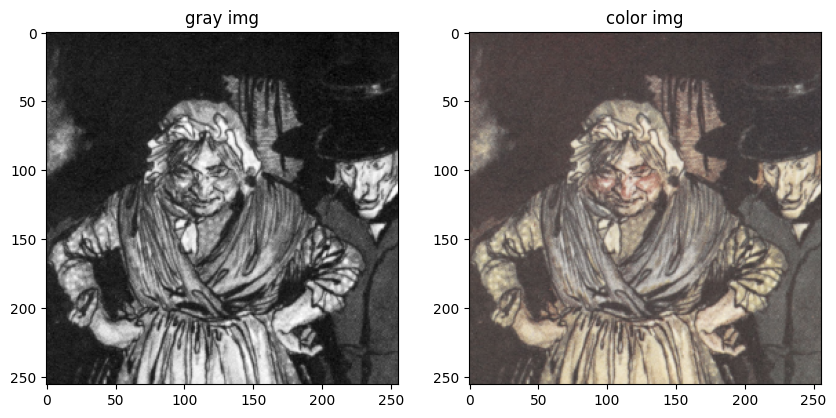

In [8]:
fig = plt.figure(figsize = (10, 5))
rows = 1
cols = 2

for X in train_loader:

  print(X['A'].shape, X['B'].shape)

  ax1 = fig.add_subplot(rows, cols, 1)
  ax1.imshow(reNormalize(X['A'][0], gray_mean, gray_std).reshape(img_height, img_width), cmap = 'gray')
  ax1.set_title('gray img')

  ax2 = fig.add_subplot(rows, cols, 2)
  ax2.imshow(reNormalize(X['B'][0], color_mean, color_std))
  ax2.set_title('color img')

  plt.show()

  break

In [9]:
### test 로더

test_loader = DataLoader(
    VictorianDataset(test_root, color_transforms_= color_transforms_, gray_transforms_ = gray_transforms_),
    batch_size = test_batch_size,
    shuffle = False
)

torch.Size([6, 1, 256, 256]) torch.Size([6, 3, 256, 256])


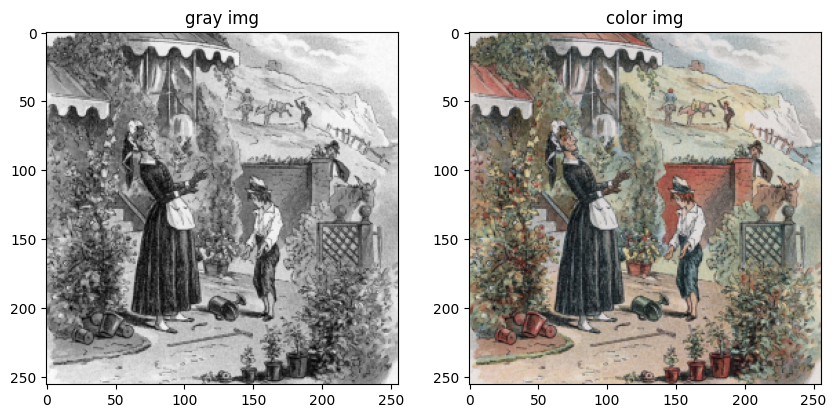

In [10]:
fig = plt.figure(figsize = (10, 5))
rows = 1
cols = 2

for X in test_loader:

  print(X['A'].shape, X['B'].shape)
  ax1 = fig.add_subplot(rows, cols, 1)
  ax1.imshow(reNormalize(X['A'][0], gray_mean, gray_std).reshape(img_height, img_width), cmap = 'gray')
  ax1.set_title('gray img')

  ax2 = fig.add_subplot(rows, cols, 2)
  ax2.imshow(reNormalize(X['B'][0], color_mean, color_std))
  ax2.set_title('color img')

  plt.show()

  break

In [11]:
##### GAN 모델 구축.

In [12]:
class Generator(nn.Module):
  def __init__(self):

    super(Generator, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels= 2, out_channels = 64, kernel_size = 3, stride = 1, padding = 1), ##
        nn.BatchNorm2d(64), # 출력 채널에 맞춰서.
        nn.LeakyReLU(0.1), # LeakyReLU가 입력값이 0보다 크면, 그대로, 0보다 작음 0.1 곱해서. 그래프 떠올려보자.
    )

    self.maxpool = nn.MaxPool2d(2, 2)


    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 64, out_channels = 64 * 2, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1)
    )

    self.upsample = nn.Sequential(
        nn.ConvTranspose2d(in_channels = 64 * 2, out_channels = 64, kernel_size = 4, stride = 2, padding = 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2)
    )

    self.conv1by1 = nn.Sequential(
        nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 1, stride = 1, padding = 0),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1)
    )

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size = 3, stride = 1, padding = 1),
        nn.Tanh()
    )

  def forward(self, input):
    output1 = self.conv1(input)

    pool1 = self.maxpool(output1)
    output2 = self.conv2(pool1)
    output3 = self.upsample(output2) + output1
    output4 = self.conv1by1(output3)

    out = self.conv(output4)

    return out

In [18]:
class Discriminator(nn.Module):
  def __init__(self):

    super(Discriminator, self).__init__()

    self.main = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 4, stride = 2, padding = 1, bias = False), ### 전에 출력 채널값 3이니, 잘 맞춰서.
        nn.LeakyReLU(0.2, inplace = True), ## inplace 인자값. 원본 데이터 필요없음, True, 원본데이터 유지하고 새로 생성하려면 False, 메모리 사용량 True쓰면 더 줄어듦.


        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 1, stride = 1, padding = 0, bias = False), ### 여기서 Generator랑 다르게 bias값 False로 준건,
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),


        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.2, inplace = True),
       )


    self. fc = nn.Sequential(
        nn.Linear(1024 * 8 * 8, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, batch_size),
        nn.Sigmoid()
    )

  def forward(self, input, b_size):
    output = self.main(input)
    output = self.fc(output.view(b_size,- 1))

    return output

Bias는 보통 BatchNorm layer를 쌓으면 무의미 하다.

<br>

그래서 보통 BatchNorm을 Conv2 계층 뒤에 있음 bias = False라고 지정해주는데, 여기서는 신기하게 최적화 때문인지, 디자인 때문에 그런건지... 암튼 그렇다.




<br>
<br>
<br>



Discriminator에만 FC 있는게 어떤 확률값을 출력해야 한다. 이 확률값은 스칼라 값이고 2D에서 1D로 변환하는 과정이 필요.

In [19]:
def weights_init(m):
  classname = m.__class__.__name__ #클래스 이름 classname에 때려박는거.

  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)

  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)

In [20]:
Gener = Generator().cuda(gpu) if torch.cuda.is_available() else Generator()
Gener.apply(weights_init)

Generator(
  (conv1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv1by1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negat

In [21]:
Discri = Discriminator().cuda(gpu) if torch.cuda.is_available() else Discriminator()
Discri.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05, momentum=0.1, 

In [23]:
max_epoch = 50

optimizerD = torch.optim.Adam(Discri.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = torch.optim.Adam(Gener.parameters(), lr = 0.0002, betas = (0.5, 0.999))

betas가 Adam 최적화에 들어가는건데,

<br>

첫번째 0.5가 모멘텀 계산.
두번째 0.999가 RMSPorp에서 사용되는 기울기 지수 평균 계산.

보통 0.9에 가깝게, 0.999에 가깝게 설정.

In [ ]:
for epoch in range(max_epoch):
  start_time = datetime.datetime.now()
  loss_D = 0.0

  for i, data in enumerate(train_loader):
    grays, color = data['A'], data['B']
    b_size = len(data['A'])

    ### Generator 학습. noise막 껴넣는거 확인.
    noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0, 1)
    gray_noise = Variable(torch.cat([grays, noise], dim = 1).cuda(gpu))
    fake_img = Gener(gray_noise)
    output = Discri(fake_img, b_size)
    g_loss = torch.mean((output -1) ** 2)


    Discri.zero_grad()
    Gener.zero_grad()
    g_loss.backward()
    optimizerG.step()


    ### Discriminator 학습

    color = Variable(color.cuda(gpu))
    noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0, 1)
    gray_noise = Variable(torch.cat)
